In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.mixture import GaussianMixture

In [2]:
df = pd.read_csv(r"C:\Users\julie\OneDrive\Skrivebord\Computational Data Analysis, 02582\Assignment 2\data\HR_data.csv", index_col=0)

# df.columns
# df["Cohort"]

In [3]:
df = df.dropna(axis=1, how="any") # Drop columns with any NaN values
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # Random shuffle of rows

target_cols = ["Cohort", "Phase", "Round"] # Target columns to predict
X_cols = list(set(df.columns) - set(target_cols))

X = df[X_cols]
y = df[target_cols]

[N, p] = X.shape
print("Number of samples:", N)
print("Number of features:", p)
minX = list(np.min(X, axis=0)) # data range min
maxX = list(np.max(X, axis=0)) # data range max


test_size = 0.1
test_split = len(X) - int(len(X) * test_size)

X_train, y_train = np.array(X[:test_split]), np.array(y[:test_split])
X_test, y_test = np.array(X[test_split:]), np.array(y[test_split:])


Number of samples: 312
Number of features: 57


## Basic K-means clustering

In [4]:
## K-means clustering

clusters = 10 # Number of clusters

kmeans = KMeans(n_clusters = clusters, n_init = 1, random_state = 1, max_iter = 1)
kmeans.fit(X_train)

# Test the clustering
y_pred = kmeans.predict(X_test)
y_pred_train = kmeans.predict(X_train)

# NOTE Find a way to evaluate the clustering, since y are string values

## Investigate the clustering results
cluster = 5 # Cluster to investigate

# Find the index of the cluster in y_test
cluster_index = np.where(y_pred == cluster)[0]
cluster_y = y_test[cluster_index] 
print(cluster_y)

[['D1_5' 'phase2' 'round_1']
 ['D1_3' 'phase3' 'round_3']
 ['D1_4' 'phase3' 'round_1']
 ['D1_1' 'phase2' 'round_2']
 ['D1_3' 'phase1' 'round_2']
 ['D1_1' 'phase2' 'round_4']
 ['D1_3' 'phase3' 'round_4']]


## Gap-statistic to select K for K-means clustering, week 9 ex3

In [5]:
clustersNr = 50
list_of_clusters = range(1,clustersNr+1)
Nsim = 50
W = np.zeros(clustersNr) # For actual data
Wu = np.zeros((clustersNr, Nsim)) # For simulated data
for nrClusters in list_of_clusters: # Want actual number included
    # kmeans first
    kmeans = KMeans(n_clusters=nrClusters, random_state=0).fit(X)
    
    # Then Compute within-class dissimilarity W given X (the data), C (the cluster centers)
    # and labelCluster (the predicted cluster numbers)
    labelCluster = kmeans.labels_ # predicted cluster numbers
    C = kmeans.cluster_centers_ # cluster centers
    
    for cluster in range(1, nrClusters + 1):
        Ik = np.where(labelCluster == cluster - 1)[0]
        dk = np.sum((X.iloc[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), C[cluster - 1, :]))**2, axis = 1)  
        Dk = np.sum(dk)
        W[nrClusters-1] += Dk
    
    
    # gap-statistic
    # Nsim simulations of data uniformly distributed over [X]
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        
        # perform K-means on the simulated data
        kmeans = KMeans(n_clusters=nrClusters, random_state=0).fit(Xu)
                
        # Compute within-class dissmiliarity for the simulated data Wu given Xu (the simulated data),
        # Cu (the cluster centers for the simulated data), and labelClusterU (the predicted cluster numbers)
        # for the simulated data).
        labelClusterU = kmeans.labels_
        Cu = kmeans.cluster_centers_

        for cluster in range(1, nrClusters + 1):
            Ik = np.where(labelClusterU == cluster - 1)[0]
            dk = np.sum((Xu[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), Cu[cluster - 1, :]))**2, axis = 1)  
            Dk = np.sum(dk)
            Wu[nrClusters-1,j] += Dk

        
# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) # standard error sk' in (14.39)
x_range = np.array(range(nrClusters)) + 1

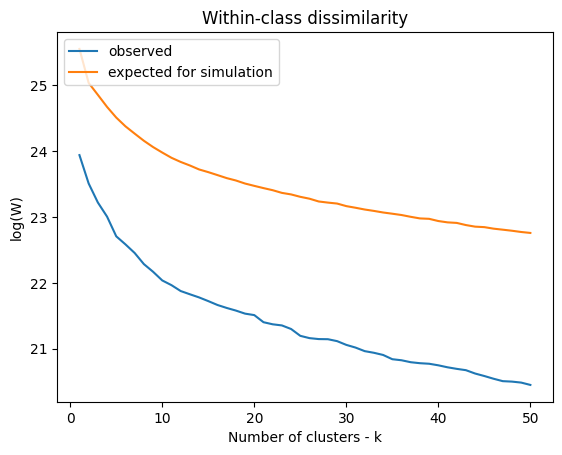

In [6]:
# Plot the log within class scatters
plt.figure()
plt.title("Within-class dissimilarity")
plt.plot(x_range, np.log(W), label='observed')
plt.plot(x_range, Elog_Wu, label='expected for simulation')
plt.legend(loc='upper left')
plt.xlabel("Number of clusters - k")
plt.ylabel("log(W)")
plt.show()

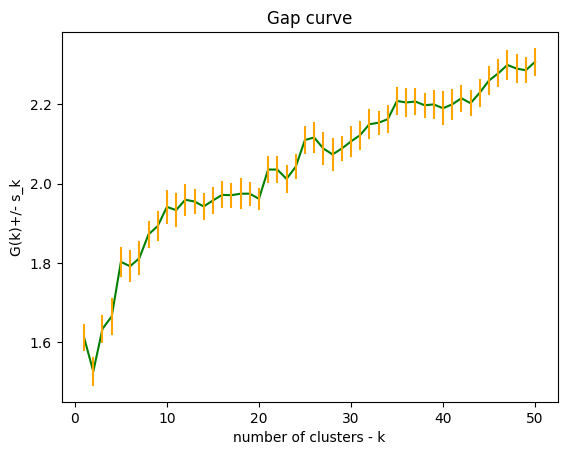

Gap-statistic, optimal K = 1


In [7]:
# plot the Gap curve
plt.figure()
plt.title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
plt.plot(x_range,Gk,color='green')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
plt.plot(x_range_list, GkList, color='orange')
plt.ylabel('G(k)+/- s_k')
plt.xlabel('number of clusters - k')
plt.show()


# Implementation of the rule for estimating K*, see ESL (14.39), p. 519
K_opt = np.where(np.array(Gk[:-1]) >= np.array(Gk[1:] - sk[1:]))[0]

if not K_opt.size:
    K_opt = clustersNr
    print ("Gap-statistic, optimal K = %d" % K_opt)
else:    
    print ("Gap-statistic, optimal K = %d" % list_of_clusters[K_opt[0]])

## Clustering with GMM, week 9 ex4

The optimal number of clusters is:
AIC:  9
BIC:  7


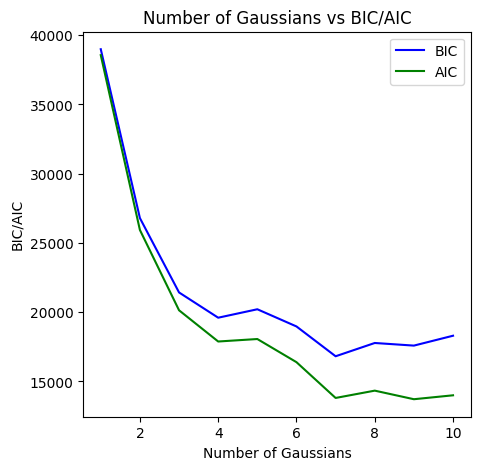

In [8]:
k = 10
BIC = np.zeros((k))
AIC = np.zeros((k))

# Investigate AIC + BIC
for k in range(1,k+1):
    # sklearns gaussianMixture has an aic and bic function that returns the AIC and BIC of the model respectively
    gmm = GaussianMixture(n_components=k, 
                          covariance_type='diag', # 'full' = each component has its own general covariance matrix, 'diag' = each component has its own diagonal covariance matrix
                          random_state=0).fit(X) #
                        #   reg_covar = 0.01).fit(X)
        # reg_covar is a regularization term to avoid singular covariance matrices. Non-negative regularization added to the diagonal of covariance. Allows to assure that the covariance matrices are all positive.
    BIC[k-1] = gmm.bic(X)
    AIC[k-1] = gmm.aic(X)

# Plot the AIC and BIC values
print('The optimal number of clusters is:')
print('AIC: ', np.argmin(AIC)+1)
print('BIC: ', np.argmin(BIC)+1)

plt.figure(figsize=(5,5))
plt.plot(np.arange(1,k+1),BIC, c='b', label="BIC")
plt.plot(np.arange(1,k+1),AIC, c='g', label="AIC")
plt.xlabel("Number of Gaussians")
plt.ylabel("BIC/AIC")
plt.legend()
plt.title("Number of Gaussians vs BIC/AIC")
plt.show()

In [9]:
## Choose the number of clusters using BIC/AIC
n_clusters = 8

gmm = GaussianMixture(n_components=n_clusters,
                      covariance_type='diag',
                      random_state=0).fit(X_train)

# Test the clustering
y_pred = gmm.predict(X_test)
y_pred_train = gmm.predict(X_train)

# NOTE Find a way to evaluate the clustering, since y are string values

## Investigate the clustering results
cluster = 7 # Cluster to investigate

# Find the index of the cluster in y_test
cluster_index = np.where(y_pred == cluster)[0]
cluster_y = y_test[cluster_index] 
print(cluster_y)


[['D1_2' 'phase2' 'round_3']
 ['D1_6' 'phase2' 'round_1']
 ['D1_5' 'phase1' 'round_2']]


## Hierarchical clustering, week ex2

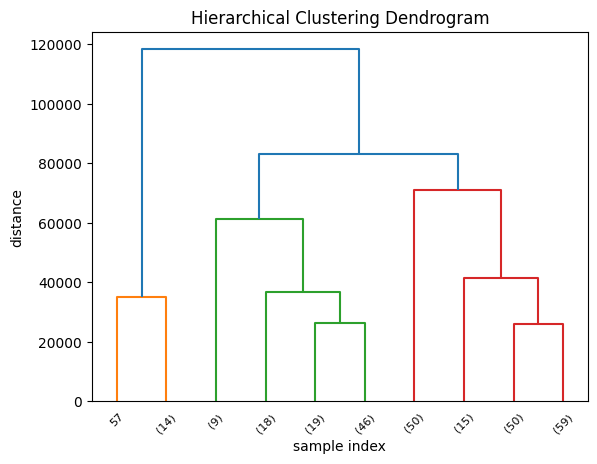

In [19]:
d_sample = 'euclidean' #See possible values: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist
    # Euclidean (works with d_group = 'ward', ...)
    # jaccard
    # mahalanobis
d_group = 'ward' #See possible values (method): https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
    # Single: nearest neighbor
    # Complete: farthest neighbor
    # Average: average distance between clusters
    # Weighted: weighted average distance between clusters
    # Centroid: distance between centroids of clusters
    # Ward: minimizes the variance of clusters being merged
N_leafs = 10 #Number of leaf nodes. n=400

Z = linkage(X_train, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance
plt.figure()
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

#for scipy dendogram look at;
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

den = dendrogram(
    Z,
    leaf_rotation=45.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p = N_leafs,
)
plt.show()